# <Center>Stock Prediction using <b>LSTM</b></center>

In [130]:
# Important Libraries
import math
import numpy as np
import pandas as pd
from datetime import date

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Visualization
import matplotlib.pyplot as plt

# Stock Data
import yfinance as yf
import locale

## Load Dataset

Load all stock from Indonesia Stock Exchange

In [194]:
# Load All Stock Ticker Code
df_ticker = pd.read_excel("Stock List.xlsx")
df_ticker.head()

,Code,Company Name,Listing Date,Shares,Listing Board
0,PACK,Solusi Kemasan Digital Tbk.,08 Feb 2023,"1,537,546,000",Acceleration
1,VAST,Vastland Indonesia Tbk.,08 Feb 2023,"3,055,700,000",Development
2,CHIP,Pelita Teknologi Global Tbk.,08 Feb 2023,"806,000,000",Acceleration
3,HALO,Haloni Jane Tbk.,08 Feb 2023,"5,650,000,000",Development
4,AALI,Astra Agro Lestari Tbk.,09 Dec 1997,"1,924,688,333",Main


In [195]:
# Check the Dataframe type
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Code           842 non-null    object
 1   Company Name   842 non-null    object
 2   Listing Date   842 non-null    object
 3   Shares         842 non-null    object
 4   Listing Board  842 non-null    object
dtypes: object(5)
memory usage: 33.0+ KB


convert the `Listing Date` to datetime Dtype

In [196]:
# Change the 'Agt' to 'Aug', since the datetime don't recognize 'Agt'
df_ticker['Listing Date'] = df_ticker['Listing Date'].str.replace('Agt','Aug')
# Change df_ticker['Listing Date'] to datetime
df_ticker['Listing Date'] = pd.to_datetime(df_ticker['Listing Date'])

In [197]:
# Check the Dataframe type again
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Code           842 non-null    object        
 1   Company Name   842 non-null    object        
 2   Listing Date   842 non-null    datetime64[ns]
 3   Shares         842 non-null    object        
 4   Listing Board  842 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 33.0+ KB


removing the suspend or used to suspended stock from list, since a suspended stock usually have a serious concern about the company's financial information. We will remove the stock from our list and won't bring them back again unless the company financial situation become better.

In [198]:
# suspended or delisting stock
suspend = ['BAPI','BTEL','CSMI','DPUM','GAMA','HDTX','KPAS','LCGP','MAGP','MINA','MIRA','RONY','NIPS','PLAS','SCPI','SUGI','TRIL','RICY','TRIO']
# remove the suspended stock
df_ticker = df_ticker[~df_ticker['Code'].isin(suspend)]

In [199]:
locale.setlocale( locale.LC_ALL, 'id_ID' )
# to filter the stock, find the stock with listing date more than 1 Year
timestamp = pd.to_datetime('01 Jan 2022', format='%d %b %Y')

# make empty list for the data
stock_code = []
stock_mrkt_cap = []

# looping through the list to append to the empty list
for i in range(len(df_ticker)):
    if df_ticker['Listing Date'].iloc[i] < timestamp:
        stock_ticker = df_ticker['Code'].iloc[i]+".JK"
        stock_info = yf.Ticker(stock_ticker).fast_info
        mrkt_cap = stock_info.get('marketCap')
        stock_code.append(df_ticker['Code'].iloc[i])
        stock_mrkt_cap.append(mrkt_cap)
        
# make dataframe from lists
df_mrkt_cap = pd.DataFrame(
    {'Stock Ticker' : stock_code,
     'Market Cap' : stock_mrkt_cap}
)

In [204]:
# sort by marketcap
df_mrkt_cap = df_mrkt_cap.sort_values(by='Market Cap',ascending=False).reset_index().drop(columns='index')
print('Top 100 Indonesian Stock with Most Market Cap')
df_mrkt_cap.head(100)

Top 100 Indonesian Stock with Most Market Cap


,Stock Ticker,Market Cap
0,BBCA,1.081738e+15
1,BBRI,7.281622e+14
2,BYAN,6.241660e+14
3,BMRI,4.748337e+14
4,TLKM,3.704926e+14
...,...,...
95,FASW,1.480539e+13
96,SSMS,1.476375e+13
97,SMAR,1.471997e+13
98,CITA,1.465333e+13


## Calculate the stock volatility each year

what is stock volatility? Volatility is a statistical measure of the dispersion of returns for a given security or market index. In most cases, the higher the volatility, the riskier the security, vice versa. based on [Forbes](https://stackoverflow.com/questions/25692293/inserting-a-link-to-a-webpage-in-an-ipython-notebook), good volatility is 15%. But what does 15% Volatility mean? it means the stock can gain or loss 15% in value. So lets calculate the top 100 stock volatility.

## Load the Price History

In [3]:
# enter the stock ticker kode
stock = "BBCA"
stock_ticker = stock+".JK"
stock_interval = '1wk'

In [197]:
# Get the Stock Price History
today = date.today()
df = yf.download(stock_ticker, start='2000-01-01', end=today, interval=stock_interval)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-07,175.0,182.5,175.0,180.0,109.807243,1094860000
2004-06-14,180.0,182.5,175.0,177.5,108.282158,1173840000
2004-06-21,177.5,182.5,175.0,182.5,111.332336,1203550000
2004-06-28,182.5,187.5,175.0,180.0,109.807243,1369070000
2004-07-05,180.0,190.0,180.0,190.0,131.713242,1875060000
...,...,...,...,...,...,...
2023-01-16,8050.0,8375.0,8050.0,8300.0,8300.000000,454472500
2023-01-23,8300.0,8850.0,8200.0,8700.0,8700.000000,382986000
2023-01-30,8725.0,8775.0,8400.0,8700.0,8700.000000,517355700


In [180]:
df.shape

(479, 6)

In [181]:
df[['Close']].describe()

,Close
count,479.000000
mean,493.194124
std,230.986090
min,225.280212
25%,275.397614
50%,411.855896
75%,717.500000
max,1040.000000


In [182]:
# Remove the outlier/error in the dataset, since the sido stock never reach 94.500
# df['Close'][df['Close'] == df['Close'].max()]=945

## Visualize the Stock Price History

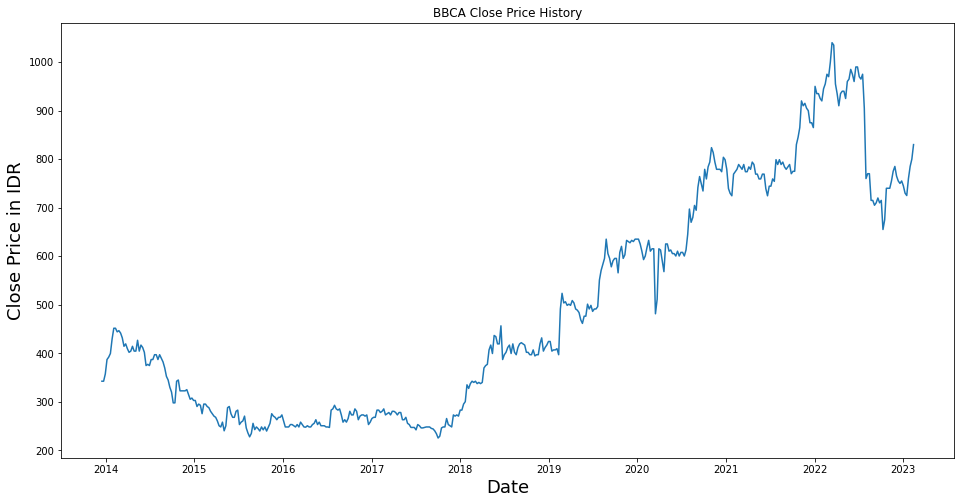

In [183]:
plt.figure(figsize=(16,8))
plt.title('BBCA Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price in IDR',fontsize=18)
plt.show()

## Data Preprocessing

In [184]:
# New Dataframe Close Only
data = df.filter(['Close'])
# Convert to Numpy Array
dataset = data.values
# Number of rows will be used to train the model
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

384

In [185]:
# Scale the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [186]:
# Create the training dataset from 0 to 1818
train_data = scaled_data[ :training_data_len, : ]

# split the data to x_train and y_train
x_train = []
y_train = []

# Create a 60-days window of historical prices (i-60) as our feature data 
# (x_train) and the following 60-days window as label data (y_train).
for i in range(12, len(train_data)):
    x_train.append(train_data[i-12:i, 0])
    y_train.append(train_data[i, 0])
    
# Reshape the x_train and y_train to numpy as tensorflow only accept numpy
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Setting the LSTM Network Architecture

In [187]:
# Build the Model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 12, 100)           40800     
                                                                 
 lstm_19 (LSTM)              (None, 50)                30200     
                                                                 
 dense_18 (Dense)            (None, 25)                1275      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 72,301
Trainable params: 72,301
Non-trainable params: 0
_________________________________________________________________


In [188]:
# Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [189]:
# Train the Model
model.fit(x_train, y_train, batch_size= 1, epochs=100)

Epoch 1/100
372/372 [==============================] - 3s 4ms/step - loss: 0.0032
Epoch 2/100
372/372 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 3/100
372/372 [==============================] - 2s 4ms/step - loss: 0.0016
Epoch 4/100
372/372 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 5/100
372/372 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 6/100
372/372 [==============================] - 1s 4ms/step - loss: 0.0010
Epoch 7/100
372/372 [==============================] - 1s 4ms/step - loss: 8.9264e-04
Epoch 8/100
372/372 [==============================] - 1s 4ms/step - loss: 8.7796e-04
Epoch 9/100
372/372 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 10/100
372/372 [==============================] - 1s 4ms/step - loss: 8.7374e-04
Epoch 11/100
372/372 [==============================] - 1s 4ms/step - loss: 7.5364e-04
Epoch 12/100
372/372 [==============================] - 1s 4ms/step - loss: 9.05

## Create Testing Dataset

In [190]:
# Create test data from 1818-60 to end of rows
test_data = scaled_data[training_data_len-12: , : ]
# create data test x_test and y_test
x_test = []
y_test = dataset[training_data_len:]

for i in range(12, len(test_data)):
  x_test.append(test_data[i-12:i, 0])
# Reshape the x_test to numpy as tensorflow only accept numpy
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Get the predict data

In [191]:
# predict the x_test
prediction = model.predict(x_test)

3/3 [==============================] - 1s 5ms/step


In [192]:
# inverse scale the predict result
prediction_unscaled = scaler.inverse_transform(prediction)

In [193]:
# get the RMSE Score
rmse=np.sqrt(np.mean(((prediction_unscaled- y_test)**2)))
rmse

32.69095347582535

## Visualize the Prediction results

C:\Users\aaron\AppData\Local\Temp\ipykernel_16308\312296751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = prediction_unscaled


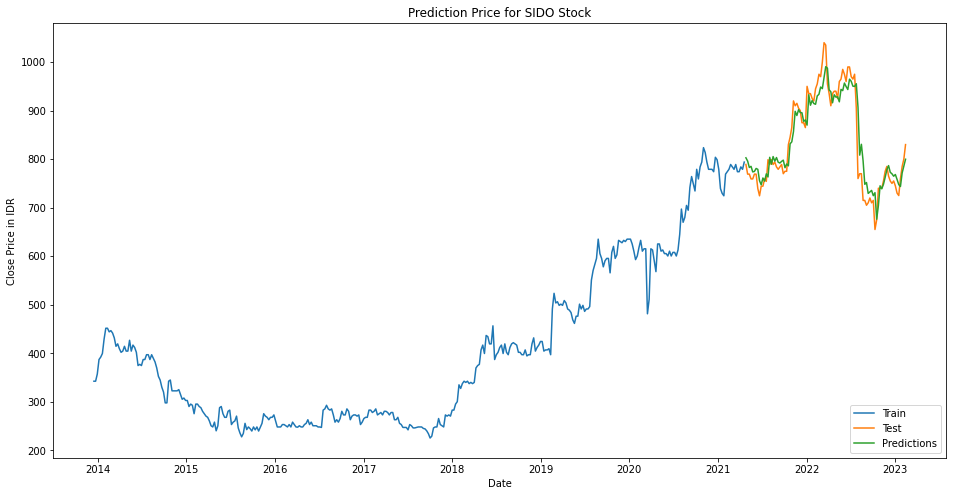

In [194]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = prediction_unscaled
plt.figure(figsize=(16,8))
plt.title('Prediction Price for SIDO Stock')
plt.xlabel('Date')
plt.ylabel('Close Price in IDR')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

# Predict the Stock Price from Now ON

In [195]:
# get the stock data
df
# create new dataframe
new_df = df.filter(['Close'])
# the last 7 month closing price value
last_7 = new_df[-7:].values
# scale the last 7 month
last_7_scaled = scaler.transform(last_7)
# empty list
x_test = []
# append the past 7 month
x_test.append(last_7_scaled)
# convert to numpy
x_test = np.array(x_test)
# reshape
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
# get the predicted scaled price
pred_price = model.predict(x_test)
# inverse scale
pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

1/1 [==============================] - 1s 590ms/step
[[820.4284]]
